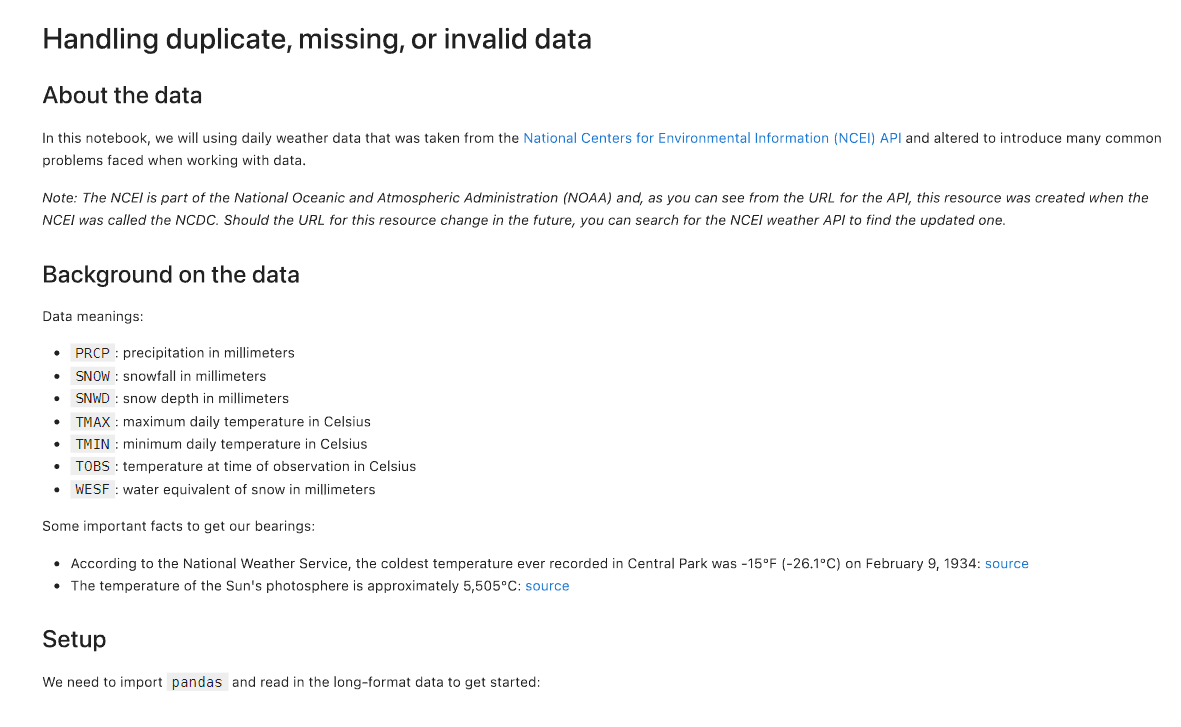

In [2]:
import pandas as pd
df = pd.read_csv('dirty_data.csv')

#Finding problematic data
A good first step is to look at some rows:

In [3]:
df.head()

,date,station,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF,inclement_weather
0,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
1,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
3,2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-8.3,-16.1,-12.2,NaN,False
4,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False


Looking at summary statistics can reveal strange or missing values:

In [4]:
df.describe()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF
count,765.000000,577.000000,577.0,765.000000,765.000000,398.000000,11.000000
mean,5.360392,4.202773,NaN,2649.175294,-15.914379,8.632161,16.290909
std,10.002138,25.086077,NaN,2744.156281,24.242849,9.815054,9.489832
min,0.000000,0.000000,-inf,-11.700000,-40.000000,-16.100000,1.800000
25%,0.000000,0.000000,NaN,13.300000,-40.000000,0.150000,8.600000
50%,0.000000,0.000000,NaN,32.800000,-11.100000,8.300000,19.300000
75%,5.800000,0.000000,NaN,5505.000000,6.700000,18.300000,24.900000
max,61.700000,229.000000,inf,5505.000000,23.900000,26.100000,28.700000


The info() method can pinpoint missing values and wrong data types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               765 non-null    object 
 1   station            765 non-null    object 
 2   PRCP               765 non-null    float64
 3   SNOW               577 non-null    float64
 4   SNWD               577 non-null    float64
 5   TMAX               765 non-null    float64
 6   TMIN               765 non-null    float64
 7   TOBS               398 non-null    float64
 8   WESF               11 non-null     float64
 9   inclement_weather  408 non-null    object 
dtypes: float64(7), object(3)
memory usage: 59.9+ KB


We can use pd.isnull() / pd.isna() or the isna() / isnull() method of the series to find nulls:

In [6]:
contain_nulls = df[
df.SNOW.isnull() | df.SNWD.isna()\
| pd.isnull(df.TOBS) | pd.isna(df.WESF)\
| df.inclement_weather.isna()
]
contain_nulls.shape[0]

765

In [7]:
contain_nulls.head(10)

,date,station,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF,inclement_weather
0,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
1,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
3,2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-8.3,-16.1,-12.2,NaN,False
4,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
5,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
6,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
7,2018-01-04T00:00:00,?,20.6,229.0,inf,5505.0,-40.0,NaN,19.3,True
8,2018-01-04T00:00:00,?,20.6,229.0,inf,5505.0,-40.0,NaN,19.3,True
9,2018-01-05T00:00:00,?,0.3,NaN,NaN,5505.0,-40.0,NaN,NaN,NaN


Note that we can't check if we have NaN like this:

In [9]:
df[df.inclement_weather == 'NaN'].shape[0]

0

This is because it is actually np.nan . However, notice this also doesn't work:

In [10]:
import numpy as np
df[df.inclement_weather == np.nan].shape[0]

0

We have to use one of the methods discussed earlier for this to work:

In [11]:
df[df.inclement_weather.isna()].shape[0]

357

We can find -inf / inf by comparing to -np.inf / np.inf :

In [12]:
df[df.SNWD.isin([-np.inf, np.inf])].shape[0]

577

Rather than do this for each column, we can write a function that will use a dictionary comprehension to check all the columns for us

In [15]:
import numpy as np
def get_inf_count(df):
  return {
col : df[df[col].isin([np.inf, -np.inf])].shape[0] for col in df.columns
}
get_inf_count(df)

{'date': 0,
 'station': 0,
 'PRCP': 0,
 'SNOW': 0,
 'SNWD': 577,
 'TMAX': 0,
 'TMIN': 0,
 'TOBS': 0,
 'WESF': 0,
 'inclement_weather': 0}

Before we can decide how to handle the infinite values of snow depth, we should look at the summary statistics for snowfall which form a big part in determining the snow
depth:

In [16]:
pd.DataFrame({
'np.inf Snow Depth': df[df.SNWD == np.inf].SNOW.describe(),
'-np.inf Snow Depth': df[df.SNWD == -np.inf].SNOW.describe()
}).T

,count,mean,std,min,25%,50%,75%,max
np.inf Snow Depth,24.0,101.041667,74.498018,13.0,25.0,120.5,152.0,229.0
-np.inf Snow Depth,553.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Let's now look into the date and station columns. We saw the ? for station earlier, so we know that was the other unique value. However, we see that some dates are
present 8 times in the data and we only have 324 days meaning we are also missing days:

In [17]:
df.describe(include='object')

,date,station,inclement_weather
count,765,765,408
unique,324,2,2
top,2018-07-05T00:00:00,GHCND:USC00280907,False
freq,8,398,384


We can use the duplicated() method to find duplicate rows:

In [18]:
df[df.duplicated()].shape[0]

284

The default for keep is 'first' meaning it won't show the first row that the duplicated data was seen in; we can pass in False to see it though

In [19]:
df[df.duplicated(keep=False)].shape[0]

482

We can also specify the columns to use:

In [20]:
df[df.duplicated(['date', 'station'])].shape[0]

284

Let's look at a few duplicates. Just in the few values we see here, we know that the top 4 are actually in the data 6 times because by default we aren't seeing their first
occurrence:

In [21]:
df[df.duplicated()].head()

,date,station,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF,inclement_weather
1,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2,2018-01-01T00:00:00,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
5,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
6,2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False
8,2018-01-04T00:00:00,?,20.6,229.0,inf,5505.0,-40.0,NaN,19.3,True


#Mitigating Issues

Handling duplicated data

Since we know we have NY weather data and noticed we only had two entries for station , we may decide to drop the station column because we are only interested in
the weather data. However, when dealing with duplicate data, we need to think of the ramifications of removing it. Notice we only have data for the WESF column when the
station is ? :

In [22]:
df[df.WESF.notna()].station.unique()

array(['?'], dtype=object)

If we determine it won't impact our analysis, we can use drop_duplicates() to remove them

In [23]:
# save this information for later
station_qm_wesf = df[df.station == '?'].WESF
# sort ? to the bottom
df.sort_values('station', ascending=False, inplace=True)
# drop duplicates based on the date column keeping the first occurrence
# which will be the valid station if it has data
df_deduped = df.drop_duplicates('date').drop(
# remove the station column because we are done with it
# and WESF because we need to replace it later
columns=['station', 'WESF']
).sort_values('date').assign( # sort by the date
# add back the WESF column which will be properly matched because of the index
WESF=station_qm_wesf
)
df_deduped.shape


(324, 9)

Check out the 4th row, we have WESF in the correct spot thanks to the index:

In [24]:
df_deduped.head()

,date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
0,2018-01-01T00:00:00,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
3,2018-01-02T00:00:00,0.0,0.0,-inf,-8.3,-16.1,-12.2,False,NaN
6,2018-01-03T00:00:00,0.0,0.0,-inf,-4.4,-13.9,-13.3,False,NaN
8,2018-01-04T00:00:00,20.6,229.0,inf,5505.0,-40.0,NaN,True,19.3
11,2018-01-05T00:00:00,14.2,127.0,inf,-4.4,-13.9,-13.9,True,NaN


#Dealing with nulls
We could drop nulls, replace them with some arbitrary value, or impute them using the surrounding data. Each of these options may have ramifications, so we must choose
wisely.
We can use dropna() to drop rows where any column has a null value. The default options leave us without data:

In [25]:
df_deduped.dropna().shape

(0, 9)

If we pass how='all' , we can choose to only drop rows where everything is null, but this removes nothing

In [26]:
df_deduped.dropna(how='all').shape

(324, 9)

We can use just a subset of columns to determine what to drop with the subset argument

In [27]:
df_deduped.dropna(
how='all', subset=['inclement_weather', 'SNOW', 'SNWD']
).shape

(293, 9)

This can also be performed along columns, and we can also require a certain number of null values before we drop the data:

In [28]:
df_deduped.dropna(axis='columns', thresh=df_deduped.shape[0]*.75).columns

Index(['date', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS',
       'inclement_weather'],
      dtype='object')

We can choose to fill in the null values instead with fillna() :

In [29]:
df_deduped.loc[:,'WESF'].fillna(0, inplace=True)
df_deduped.head()

,date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
0,2018-01-01T00:00:00,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,0.0
3,2018-01-02T00:00:00,0.0,0.0,-inf,-8.3,-16.1,-12.2,False,0.0
6,2018-01-03T00:00:00,0.0,0.0,-inf,-4.4,-13.9,-13.3,False,0.0
8,2018-01-04T00:00:00,20.6,229.0,inf,5505.0,-40.0,NaN,True,19.3
11,2018-01-05T00:00:00,14.2,127.0,inf,-4.4,-13.9,-13.9,True,0.0


Here, we will use 'ffill' to show how this works:


In [30]:
df_deduped.assign(
TMAX=lambda x: x.TMAX.replace(5505, np.nan).fillna(method='ffill'),
TMIN=lambda x: x.TMIN.replace(-40, np.nan).fillna(method='ffill')
).head()

,date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
0,2018-01-01T00:00:00,0.0,0.0,-inf,NaN,NaN,NaN,NaN,0.0
3,2018-01-02T00:00:00,0.0,0.0,-inf,-8.3,-16.1,-12.2,False,0.0
6,2018-01-03T00:00:00,0.0,0.0,-inf,-4.4,-13.9,-13.3,False,0.0
8,2018-01-04T00:00:00,20.6,229.0,inf,-4.4,-13.9,NaN,True,19.3
11,2018-01-05T00:00:00,14.2,127.0,inf,-4.4,-13.9,-13.9,True,0.0


We can use np.nan_to_num() to turn np.nan into 0 and -np.inf / np.inf into large negative or positive finite numbers

In [31]:
df_deduped.assign(
SNWD=lambda x: np.nan_to_num(x.SNWD)
).head()

,date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
0,2018-01-01T00:00:00,0.0,0.0,-1.797693e+308,5505.0,-40.0,NaN,NaN,0.0
3,2018-01-02T00:00:00,0.0,0.0,-1.797693e+308,-8.3,-16.1,-12.2,False,0.0
6,2018-01-03T00:00:00,0.0,0.0,-1.797693e+308,-4.4,-13.9,-13.3,False,0.0
8,2018-01-04T00:00:00,20.6,229.0,1.797693e+308,5505.0,-40.0,NaN,True,19.3
11,2018-01-05T00:00:00,14.2,127.0,1.797693e+308,-4.4,-13.9,-13.9,True,0.0


We can couple fillna() with other types of calculations for interpolation. Here we replace missing values of TMAX with the median of all TMAX values, TMIN with the
median of all TMIN values, and TOBS to the average of the TMAX and TMIN values. Since we place TOBS last, we have access to the imputed values for TMIN and
TMAX in the calculation. WARNING: the text has a typo and fills in TMAX with TMIN's median, the below is correct.

In [32]:
df_deduped.assign(
TMAX=lambda x: x.TMAX.replace(5505, np.nan).fillna(x.TMAX.median()),
TMIN=lambda x: x.TMIN.replace(-40, np.nan).fillna(x.TMIN.median()),
# average of TMAX and TMIN
TOBS=lambda x: x.TOBS.fillna((x.TMAX + x.TMIN) / 2)
).head()

,date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
0,2018-01-01T00:00:00,0.0,0.0,-inf,22.8,0.0,11.4,NaN,0.0
3,2018-01-02T00:00:00,0.0,0.0,-inf,-8.3,-16.1,-12.2,False,0.0
6,2018-01-03T00:00:00,0.0,0.0,-inf,-4.4,-13.9,-13.3,False,0.0
8,2018-01-04T00:00:00,20.6,229.0,inf,22.8,0.0,11.4,True,19.3
11,2018-01-05T00:00:00,14.2,127.0,inf,-4.4,-13.9,-13.9,True,0.0


We can also use apply() for running the same calculation across columns. For example, let's fill all missing values with their rolling 7 day median of their values, setting the
number of periods required for the calculation to 0 to ensure we don't introduce more extra NaN values. (Rolling calculations will be covered in chapter 4.) We need to set
the date column as the index so apply() doesn't try to take the rolling 7 day median of the date:

In [33]:
df_deduped.assign(
# make TMAX and TMIN NaN where appropriate
TMAX=lambda x: x.TMAX.replace(5505, np.nan),
TMIN=lambda x: x.TMIN.replace(-40, np.nan)
).set_index('date').apply(
# rolling calculations will be covered in chapter 4, this is a rolling 7 day median
# we set min_periods (# of periods required for calculation) to 0 so we always get a result
lambda x: x.fillna(x.rolling(7, min_periods=0).median())
).head(10)


,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
date,,,,,,,,
2018-01-01T00:00:00,0.0,0.0,-inf,NaN,NaN,NaN,NaN,0.0
2018-01-02T00:00:00,0.0,0.0,-inf,-8.30,-16.1,-12.20,False,0.0
2018-01-03T00:00:00,0.0,0.0,-inf,-4.40,-13.9,-13.30,False,0.0
2018-01-04T00:00:00,20.6,229.0,inf,-6.35,-15.0,-12.75,True,19.3
2018-01-05T00:00:00,14.2,127.0,inf,-4.40,-13.9,-13.90,True,0.0
2018-01-06T00:00:00,0.0,0.0,-inf,-10.00,-15.6,-15.00,False,0.0
2018-01-07T00:00:00,0.0,0.0,-inf,-11.70,-17.2,-16.10,False,0.0
2018-01-08T00:00:00,0.0,0.0,-inf,-7.80,-16.7,-8.30,False,0.0
2018-01-10T00:00:00,0.0,0.0,-inf,5.00,-7.8,-7.80,False,0.0


The last strategy we could try is interpolation with the interpolate() method. We specify the method parameter with the interpolation strategy to use. There are many
options, but we will stick with the default of 'linear' , which will treat values as evenly spaced and place missing values in the middle of existing ones. We have some
missing data, so we will reindex first. Look at January 9th, which we didn't have before—the values for TMAX , TMIN , and TOBS are the average of values the day prior
(January 8th) and the day after (January 10th):

In [34]:
df_deduped.assign(
# make TMAX and TMIN NaN where appropriate
TMAX=lambda x: x.TMAX.replace(5505, np.nan),
TMIN=lambda x: x.TMIN.replace(-40, np.nan),
date=lambda x: pd.to_datetime(x.date)
).set_index('date').reindex(
pd.date_range('2018-01-01', '2018-12-31', freq='D')
).apply(
lambda x: x.interpolate()
).head(10)

,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,inclement_weather,WESF
2018-01-01,0.0,0.0,-inf,NaN,NaN,NaN,NaN,0.0
2018-01-02,0.0,0.0,-inf,-8.3,-16.10,-12.20,False,0.0
2018-01-03,0.0,0.0,-inf,-4.4,-13.90,-13.30,False,0.0
2018-01-04,20.6,229.0,inf,-4.4,-13.90,-13.60,True,19.3
2018-01-05,14.2,127.0,inf,-4.4,-13.90,-13.90,True,0.0
2018-01-06,0.0,0.0,-inf,-10.0,-15.60,-15.00,False,0.0
2018-01-07,0.0,0.0,-inf,-11.7,-17.20,-16.10,False,0.0
2018-01-08,0.0,0.0,-inf,-7.8,-16.70,-8.30,False,0.0
2018-01-09,0.0,0.0,-inf,-1.4,-12.25,-8.05,NaN,0.0
2018-01-10,0.0,0.0,-inf,5.0,-7.80,-7.80,False,0.0
